In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
turnover=pd.read_csv('D:/turnover/notebook/data/ML_data/turnover.csv',encoding='latin1')

In [4]:
turnover.head()

,POSITION,PROMOTION,ASSIGNMENTs,SALARY,SENIORITY_YEARS,GENDER,ABSENCES,TURNOVER
0,operations,0,3,low,5.0,0,180.866070,no
1,operations,0,3,medium,6.0,0,182.708149,no
2,support,0,3,medium,6.0,0,184.416084,no
3,logistics,0,4,high,8.0,0,188.707545,no
4,sales,0,3,high,5.0,1,179.821083,no


In [5]:
turnover.isnull().sum()

POSITION           0
PROMOTION          0
ASSIGNMENTs        0
SALARY             0
SENIORITY_YEARS    0
GENDER             0
ABSENCES           0
TURNOVER           0
dtype: int64

In [6]:
turnover['SALARY'] = turnover['SALARY'].map( {'high':2 ,'medium': 1, 'low': 0} ).astype(int)

In [7]:
turnover.dtypes

POSITION            object
PROMOTION            int64
ASSIGNMENTs          int64
SALARY               int32
SENIORITY_YEARS    float64
GENDER               int64
ABSENCES           float64
TURNOVER            object
dtype: object

In [8]:
turnover[['POSITION']]=turnover[['POSITION']].astype('category')
turnover['TURNOVER'] = turnover['TURNOVER'].replace({'no':0,'yes':1})
turnover[['TURNOVER']]=turnover[['TURNOVER']].astype('int')

In [9]:
turnover.dtypes

POSITION           category
PROMOTION             int64
ASSIGNMENTs           int64
SALARY                int32
SENIORITY_YEARS     float64
GENDER                int64
ABSENCES            float64
TURNOVER              int32
dtype: object

In [10]:
turnover.shape

(9540, 8)

In [11]:
turnover_rate = turnover.TURNOVER.value_counts() / len(turnover)
turnover_rate

TURNOVER
0    0.708176
1    0.291824
Name: count, dtype: float64

In [13]:
turnover_Summary = turnover.groupby('TURNOVER')
turnover_Summary.describe()

PROMOTION                                              ASSIGNMENTs  \
             count      mean       std  min  25%  50%  75%  max       count   
TURNOVER                                                                      
0           6756.0  0.034340  0.182114  0.0  0.0  0.0  0.0  1.0      6756.0   
1           2784.0  0.020474  0.141641  0.0  0.0  0.0  0.0  1.0      2784.0   

                    ... GENDER      ABSENCES                        \
              mean  ...    75%  max    count        mean       std   
TURNOVER            ...                                              
0         3.279455  ...    0.0  1.0   6756.0  184.637605  4.277948   
1         3.263649  ...    0.0  1.0   2784.0  184.719730  3.802574   

                                                                     
                 min        25%         50%         75%         max  
TURNOVER                                                             
0         172.297984  181.37894  184.088608  187.731785  200.861656  
1         171.374060  181.75742  186.303857  187.725100  193.255034  

[2 rows x 48 columns]

#### Does SALARY affects TURNOVER?

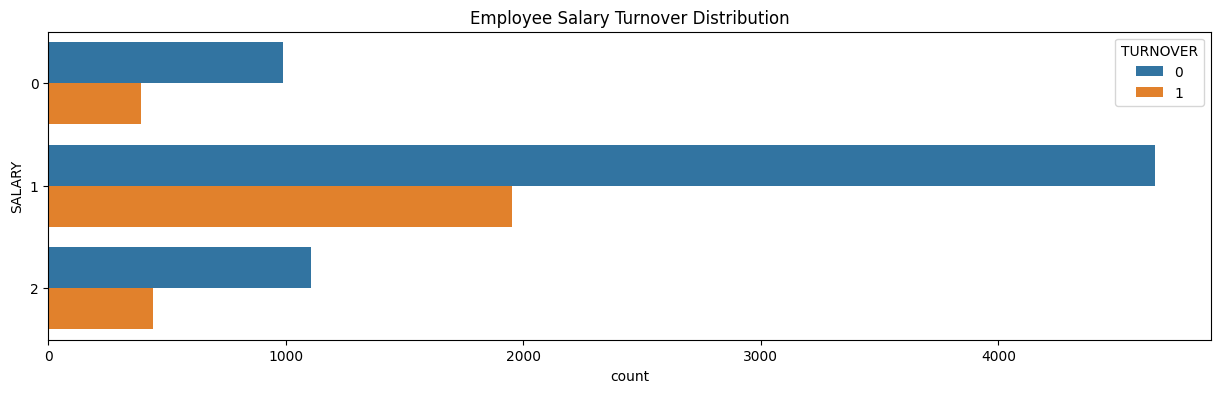

In [15]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="SALARY", hue='TURNOVER', data=turnover).set_title('Employee Salary Turnover Distribution');

In [18]:
percentage_by_salary = turnover[turnover['TURNOVER'] == 'yes'].groupby('SALARY').size() / turnover.groupby('SALARY').size() * 100
percentage_by_salary

SALARY
0   NaN
1   NaN
2   NaN
dtype: float64

We don't notice a clear impact of the SALARY on the turnover rate

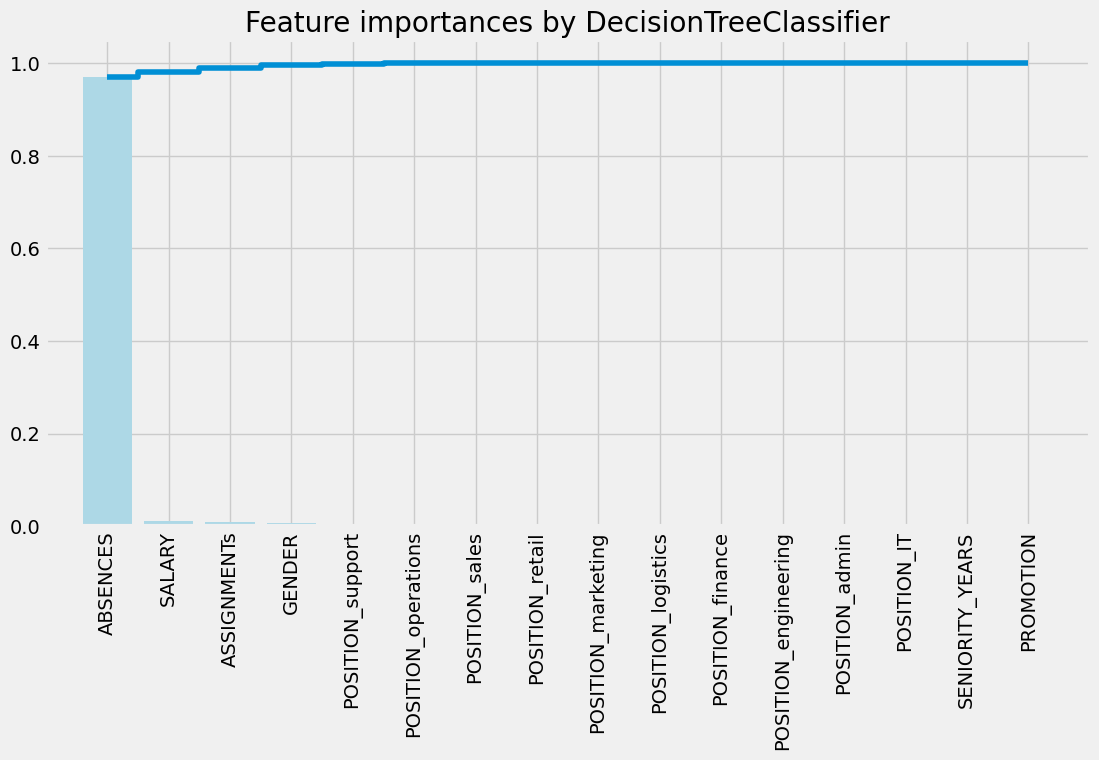

In [19]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

df_encoded = pd.get_dummies(turnover, columns=['POSITION'])

# Create train and test splits
target_name = 'TURNOVER'
X = df_encoded.drop('TURNOVER', axis=1)

y=df_encoded[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df_encoded.drop(['TURNOVER'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

We can conclude that ABSENCES has the most importance in predicting our target variable, and there is SALARY, ASSIGNEMENTS and GENDER that contribute to the predictions

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [21]:
def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

In [22]:
y_base_rate = base_rate_model(X_test)
from sklearn.metrics import accuracy_score
print ("Base rate accuracy is %2.2f" % accuracy_score(y_test, y_base_rate))

Base rate accuracy is 0.71


In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=1)

model.fit(X_train, y_train)
print ("Logistic accuracy is %2.2f" % accuracy_score(y_test, model.predict(X_test)))

Logistic accuracy is 0.71


In [24]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
kfold = model_selection.KFold(n_splits=10, random_state=7,shuffle=True)
modelCV = LogisticRegression(class_weight = "balanced")
scoring = 'roc_auc'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.506 (0.019)


In [25]:
%pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
Using cached xgboost-2.0.0-py3-none-win_amd64.whl (99.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb


print ("---Base Model---")
base_roc_auc = roc_auc_score(y_test, base_rate_model(X_test))
print ("Base Rate AUC = %2.2f" % base_roc_auc)
print(classification_report(y_test, base_rate_model(X_test)))


logis = LogisticRegression(class_weight = "balanced")
logis.fit(X_train, y_train)
print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(y_test, logis.predict(X_test))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, logis.predict(X_test)))

# Decision Tree Model
dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)
print ("\n\n ---Decision Tree Model---")
dt_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
print ("Decision Tree AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))

# Random Forest Model
rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=None, 
    min_samples_split=10, 
    class_weight="balanced"
    #min_weight_fraction_leaf=0.02 
    )
rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))


# Ada Boost
ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
ada.fit(X_train,y_train)
print ("\n\n ---AdaBoost Model---")
ada_roc_auc = roc_auc_score(y_test, ada.predict(X_test))
print ("AdaBoost AUC = %2.2f" % ada_roc_auc)
print(classification_report(y_test, ada.predict(X_test)))

# SVM
svm = SVC(class_weight='balanced', probability=True)
svm.fit(X_train, y_train)
print ("\n\n ---SVM Model---")
svm_roc_auc = roc_auc_score(y_test, svm.predict(X_test))
print ("SVM AUC = %2.2f" % svm_roc_auc)
print(classification_report(y_test, svm.predict(X_test)))

# XGBoost Model
xgb_model = xgb.XGBClassifier(class_weight='balanced', random_state=42)
xgb_model.fit(X_train, y_train)
print ("\n\n ---XGBoost Model---")
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict(X_test))
print ("XGBoost AUC = %2.2f" % xgb_roc_auc)
print(classification_report(y_test, xgb_model.predict(X_test)))

---Base Model---
Base Rate AUC = 0.50
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1013
           1       0.00      0.00      0.00       418

    accuracy                           0.71      1431
   macro avg       0.35      0.50      0.41      1431
weighted avg       0.50      0.71      0.59      1431



 ---Logistic Model---
Logistic AUC = 0.48
              precision    recall  f1-score   support

           0       0.69      0.40      0.51      1013
           1       0.28      0.56      0.37       418

    accuracy                           0.45      1431
   macro avg       0.48      0.48      0.44      1431
weighted avg       0.57      0.45      0.47      1431



 ---Decision Tree Model---
Decision Tree AUC = 0.63
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      1013
           1       0.41      0.61      0.49       418

    accuracy                           0.63   

d:\turnover\turnover\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\turnover\turnover\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\turnover\turnover\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




 ---Random Forest Model---
Random Forest AUC = 0.62
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1013
           1       0.45      0.49      0.47       418

    accuracy                           0.68      1431
   macro avg       0.62      0.62      0.62      1431
weighted avg       0.69      0.68      0.68      1431



 ---AdaBoost Model---
AdaBoost AUC = 0.63
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1013
           1       0.57      0.37      0.45       418

    accuracy                           0.73      1431
   macro avg       0.67      0.63      0.64      1431
weighted avg       0.71      0.73      0.71      1431



 ---SVM Model---
SVM AUC = 0.50


d:\turnover\turnover\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\turnover\turnover\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\turnover\turnover\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1013
           1       0.00      0.00      0.00       418

    accuracy                           0.71      1431
   macro avg       0.35      0.50      0.41      1431
weighted avg       0.50      0.71      0.59      1431



 ---XGBoost Model---
XGBoost AUC = 0.59
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1013
           1       0.51      0.31      0.39       418

    accuracy                           0.71      1431
   macro avg       0.63      0.59      0.60      1431
weighted avg       0.68      0.71      0.69      1431



d:\turnover\turnover\lib\site-packages\xgboost\core.py:160: UserWarning: [21:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


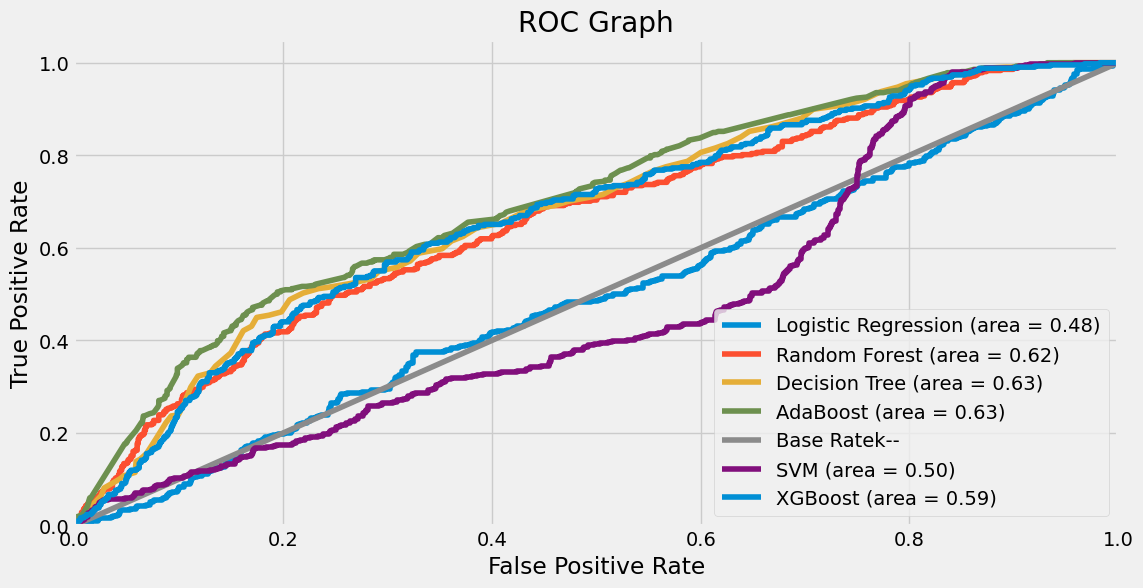

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logis.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, ada.predict_proba(X_test)[:,1])
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)

# Plot AdaBoost ROC
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (area = %0.2f)' % ada_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

# Plot SVM ROC
plt.plot(svm_fpr, svm_tpr, label='SVM (area = %0.2f)' % svm_roc_auc)

# Plot XGBoost ROC
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (area = %0.2f)' % xgb_roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()